In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.replay_buffer import PrioritizedReplayBuffer

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<div class="alert alert-warning">
TODO Add SEED
</div>

<h3>Use Cuda</h3>

In [3]:
USE_CUDA = torch.cuda.is_available()

<div class="alert alert-warning">
TODO Support GPU
</div>

<h2>Cart Pole Environment</h2>

In [4]:
env_id = "CartPole-v0"
env = gym.make(env_id)

/home/ryanlee/anaconda3/envs/rladv/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


<h2> Noisy Networks for Exploration</h2>

<p>https://arxiv.org/abs/1706.10295</p>

In [5]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(self.weight_epsilon)
            bias   = self.bias_mu   + self.bias_sigma.mul(self.bias_epsilon)
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

<h3>Noisy DQN</h3>

In [6]:
class NoisyDQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(NoisyDQN, self).__init__()
        
        self.linear =  nn.Linear(env.observation_space.shape[0], 128)
        self.noisy1 = NoisyLinear(128, 128)
        self.noisy2 = NoisyLinear(128, env.action_space.n)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.noisy1(x))
        x = self.noisy2(x)
        return x
    
    def act(self, state):
        with torch.no_grad():
            state   = torch.FloatTensor(state).unsqueeze(0)
        q_value = self.forward(state)
        action  = q_value.max(1)[1].item()
        return action
    
    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()

In [7]:
current_model = NoisyDQN(env.observation_space.shape[0], env.action_space.n)
target_model  = NoisyDQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

replay_buffer = PrioritizedReplayBuffer(10000, alpha=0.6)

<h3>Synchronize current policy net and target net</h3>

In [8]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [15]:
def compute_td_loss(batch_size, beta):
    state, action, reward, next_state, done, weights, indices = replay_buffer.sample(batch_size, beta) 

    state      = torch.FloatTensor(np.float32(state))
    # TODO Not using torch.no_grad()?
    next_state = torch.FloatTensor(np.float32(next_state))
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done.astype(float))
    weights    = torch.FloatTensor(weights)

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss  = (q_value - expected_q_value.detach()).pow(2) * weights
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [16]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

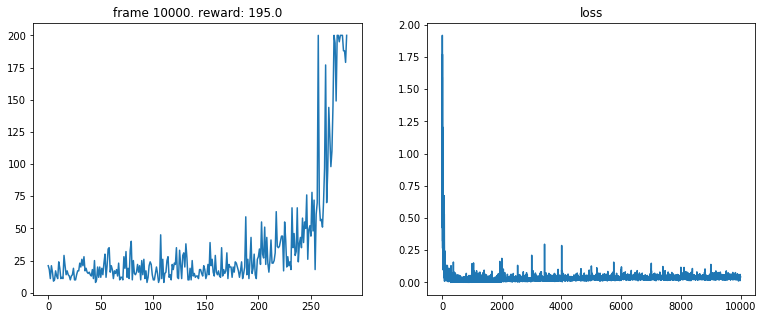

In [17]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(batch_size, beta)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)

<p><hr></p>

<h1>Atari Environment</h1>

<div class="alert alert-warning">
TODO Test on Atari
</div>

In [ ]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [ ]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [ ]:
class NoisyCnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(NoisyCnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.noisy1 = NoisyLinear(self.feature_size(), 512)
        self.noisy2 = NoisyLinear(512, env.action_space.n)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = x / 255.
        x = self.features(x)
        x = x.view(batch_size, -1)
        
        x = F.relu(self.noisy1(x))
        x = self.noisy2(x)
        return x
    
    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()
        
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)
    
    def act(self, state):
        with torch.no_grad():
            state   = torch.FloatTensor(np.float32(state)).unsqueeze(0)
        q_value = self.forward(state)
        action  = q_value.max(1)[1].item()
        return action

In [ ]:
current_model = NoisyCnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = NoisyCnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

beta_start = 0.4
beta_frames = 100000
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

replay_buffer = PrioritizedReplayBuffer(10000, alpha=0.6)

In [ ]:
plt.plot([beta_by_frame(i) for i in range(1000000)])

In [ ]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(batch_size, beta)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)